In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, SVR
from sklearn import datasets
from sklearn.metrics import confusion_matrix, accuracy_score
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader 
import copy

import xgboost as xgb
import lightgbm as lgbm
import catboost as cbt
from sklearn_rvm import EMRVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from datetime import datetime
from sklearn.svm import OneClassSVM
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest 
from sklearn.neighbors import LocalOutlierFactor

# 🌊 Anomaly Detection for Regression2Classification Task

- Anoamly Detection은 근본적인 Regression을 Anoamly Detection으로 변경한 Task에여대하여 Anomaly Detection이 가능할까?

# Load Dataset

In [99]:
# random_seed
# rand_seed = 1024 
rand_seed = 2048 
# rand_seed = 4096

# Select Dataset

dataset_name = 'diabetes_r'
# dataset_name = 'boston_r'

if dataset_name == 'diabetes_r':
    x, y= datasets.load_diabetes(return_X_y=True)
    threshold_anomaly = 140 # min 25, median 140.5, max 346
    THRESHOLD_FOR_RECONSTRUCTION = 1.00
    THRESHOLD_FOR_DENSITY = 43 
    NUM_1ST_HIDDEN = 6 
    NUM_2ND_HIDDEN = 3 

    # df = pd.read_csv('diabetes.csv')
    # X = df.iloc[:,:-1].values   
    # y = df.iloc[:,-1].values    
elif dataset_name == 'boston_r':
    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    x = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    y = raw_df.values[1::2, 2]

    threshold_anomaly = 21 # max 50, median 21.2, min 5 
    THRESHOLD_FOR_RECONSTRUCTION = 0.95
    THRESHOLD_FOR_DENSITY = 76
    NUM_1ST_HIDDEN = 5 
    NUM_2ND_HIDDEN = 2 
else:
    pass

In [100]:
print(f'Median {np.median(y)}')
print(f'Min {np.min(y)}')
print(f'Max {np.max(y)}')

Median 140.5
Min 25.0
Max 346.0


# Split data by specific threshold
- To convert regression problem to classification problem (two class for anomaly detection)

In [101]:
print("X shape")
print(x.shape)
print("Y shape")
print(y.shape)

X shape
(442, 10)
Y shape
(442,)


In [102]:
# split the dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=rand_seed, train_size=0.8)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, random_state=rand_seed, train_size=0.8)



In [103]:
y_train_c = y_train.copy()
y_valid_c = y_valid.copy()
y_test_c = y_test.copy()

y_train_c[y_train>threshold_anomaly] = -1
y_train_c[y_train<=threshold_anomaly] = 1

y_valid_c[y_valid>threshold_anomaly] = -1
y_valid_c[y_valid<=threshold_anomaly] = 1

y_test_c[y_test>threshold_anomaly] = -1
y_test_c[y_test<=threshold_anomaly] = 1

In [104]:
# scaling by minmax scaler
scaler = MinMaxScaler()

scaler = scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_valid = scaler.transform(x_valid)

In [105]:
print('valid', len(y_valid_c[y_valid_c==-1]))
print('train', len(y_train_c[y_train_c ==-1]))
print('test', len(y_test_c[y_test_c ==-1]))

print('len train origin : ', len(x_train))
x_train_only = x_train[y_train_c==1]
print('len train origin with only true : ', len(x_train_only))

valid 36
train 140
test 45
len train origin :  282
len train origin with only true :  142


# SVR (Support Vector Regression)
- Classification using Regression

In [64]:
param_grid = [
    {'kernel': ['linear'], 'C': [1.0, 2.0, 3.0, 10., 30., 100.]},
    {'kernel': ['rbf'], 'C': [1.0, 2.0, 3.0, 5.0, 10., 30., 100.],
    'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
]

elapsed_time_kernel_svr = []

svr_regressor = SVR(kernel='rbf')
# svm_classifier = svm_classifier.fit(x_train, y_train)

start_time = datetime.now()
grid_search = GridSearchCV(svr_regressor, param_grid, cv=7, scoring="neg_mean_squared_error", verbose=2)
best_svr_regressor = grid_search.fit(x_train, y_train)
elapsed_time_kernel_svr.append((datetime.now()-start_time).total_seconds())



Fitting 7 folds for each of 48 candidates, totalling 336 fits
[CV] END ...............................C=1.0, kernel=linear; total time=   0.0s
[CV] END ...............................C=1.0, kernel=linear; total time=   0.0s
[CV] END ...............................C=1.0, kernel=linear; total time=   0.0s
[CV] END ...............................C=1.0, kernel=linear; total time=   0.0s
[CV] END ...............................C=1.0, kernel=linear; total time=   0.0s
[CV] END ...............................C=1.0, kernel=linear; total time=   0.0s
[CV] END ...............................C=1.0, kernel=linear; total time=   0.0s
[CV] END ...............................C=2.0, kernel=linear; total time=   0.0s
[CV] END ...............................C=2.0, kernel=linear; total time=   0.0s
[CV] END ...............................C=2.0, kernel=linear; total time=   0.0s
[CV] END ...............................C=2.0, kernel=linear; total time=   0.0s
[CV] END ...............................C=2.0, 

In [65]:

# y_pred = svm_classifier.predict(x_test)
start_time = datetime.now()
y_pred = best_svr_regressor.predict(x_test)
elapsed_time_kernel_svr.append((datetime.now()-start_time).total_seconds())



In [66]:
# print(np.argwhere(y_test > 300))

# print(np.argwhere(y_pred > 250))
print(y_test)

[12.7 28.  14.9 10.2 13.3 25.  21.2 22.2 12.3 31.1 19.8 24.6 22.3 19.1
 20.8 50.  26.4 18.5 18.8 19.3 46.7 33.4 41.3 23.2 12.  50.  24.  18.1
 23.9  9.7 14.6 17.8 37.2 36.1 15.4 22.1 21.4 21.9  5.  23.2 31.6 15.
 23.8 26.5 18.7 17.8 35.1 36.2 23.3 21.7 13.1 19.9 33.  23.  10.9 25.
 19.  24.7 27.  23.8 17.4 50.  21.8 50.  41.7  8.4 18.3 16.8 19.3 13.1
 23.4 44.   7.2 50.  22.  18.5 19.4 37.6 16.5 24.4 18.  23.1 38.7 27.5
 19.6 17.2 20.1 22.  29.1 17.2 23.5 21.  11.  22.  10.4 22.5 11.8 14.3
 36.5 17.4 19.9 31. ]


In [67]:
print(y_pred)

[13.83331191 27.94605011 16.32531088 13.26203649 13.74939067 23.94375922
 21.30673508 20.98042617 10.46100216 31.20807466 19.70730299 24.85014337
 24.60241557 19.0048838  21.82926886 44.14541118 26.75633596 18.44717398
 19.69823665 19.63012985 43.13063683 30.27697877 31.30011304 14.99166464
 12.01964779 32.13808545 27.18035996 16.98171199 25.83566822 10.08703533
 15.18476646 16.72958141 34.66339835 36.50818596 17.09241685 24.14320406
 20.09867381 19.03925132 13.43762144 23.32872994 31.29464321 18.62219116
 24.06239819 25.28296751 19.75601392 27.30735292 35.32214461 30.68628329
 21.58969495 20.77200869 14.76394844 19.59500474 27.45005907 24.10149594
  9.99120676 25.74291475 14.2787091  24.11184876 29.47108011 21.37420263
 16.71808633 21.70475824 21.88910769 49.46919232 46.08716563  6.20338164
 18.2697146  29.68151291 18.63781166 15.14778645 21.01314875 37.87616055
  8.05714801 38.92921626 24.22116871 21.63189434 19.97327207 41.15395867
 20.39201844 24.66248381 17.95035181 23.1971244  41

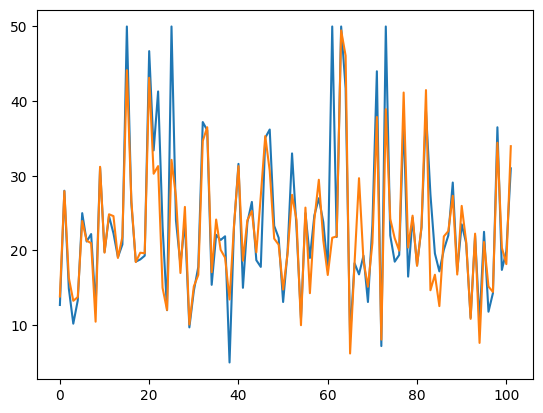

In [68]:
x = np.arange(0, len(y_test))
plt.plot(x, y_test)
plt.plot(x, y_pred)
plt.show()

In [69]:
y_pred_c = y_pred.copy()
y_pred_c[y_pred > threshold_anomaly] = -1
y_pred_c[y_pred <= threshold_anomaly] = 1

print(y_pred_c)

[ 1. -1.  1.  1.  1. -1. -1.  1.  1. -1.  1. -1. -1.  1. -1. -1. -1.  1.
  1.  1. -1. -1. -1.  1.  1. -1. -1.  1. -1.  1.  1.  1. -1. -1.  1. -1.
  1.  1.  1. -1. -1.  1. -1. -1.  1. -1. -1. -1. -1.  1.  1.  1. -1. -1.
  1. -1.  1. -1. -1. -1.  1. -1. -1. -1. -1.  1.  1. -1.  1.  1. -1. -1.
  1. -1. -1. -1.  1. -1.  1. -1.  1. -1. -1.  1.  1.  1. -1. -1. -1.  1.
 -1. -1.  1. -1.  1. -1.  1.  1. -1.  1.  1. -1.]


In [70]:
acc_svr_kernel = accuracy_score(y_test_c, y_pred_c)

In [71]:
print('Confusion Matrix\n', confusion_matrix(y_test_c, y_pred_c))
print('Best Prameters ', grid_search.best_params_)
print('Accuracy ', acc_svr_kernel)
print('Elapsed Time(train, test) ', elapsed_time_kernel_svr)

Confusion Matrix
 [[49  6]
 [ 6 41]]
Best Prameters  {'C': 30.0, 'gamma': 1.0, 'kernel': 'rbf'}
Accuracy  0.8823529411764706
Elapsed Time(train, test)  [1.499266, 0.003143]


# One-Class SVM - Linear & Kernel

In [72]:
param_grid = [
    {'kernel': ['linear'], 'nu': [0.05, 0.1, 0.25, 0,5, 0.7]},
    {'kernel': ['rbf'], 'nu': [0.05, 0.1, 0.25, 0,5, 0.7],
    'gamma': [0.01, 0.03, 0.1, 0.3, 0.05, 1.0]},
]

elapsed_time_kernel_svm = []

svm_classifier = OneClassSVM(kernel='rbf')
# svm_classifier = svm_classifier.fit(x_train, y_train)

start_time = datetime.now()
grid_search = GridSearchCV(svm_classifier, param_grid, cv=7, scoring="neg_mean_squared_error", verbose=2)
best_svm_classifier = grid_search.fit(x_train_only)
elapsed_time_kernel_svm.append((datetime.now()-start_time).total_seconds())


start_time = datetime.now()
y_pred = best_svm_classifier.predict(x_test)
elapsed_time_kernel_svm.append((datetime.now()-start_time).total_seconds())
acc_svm_kernel = accuracy_score(y_test_c, y_pred)



Fitting 7 folds for each of 42 candidates, totalling 294 fits
[CV] END .............................kernel=linear, nu=0.05; total time=   0.0s
[CV] END .............................kernel=linear, nu=0.05; total time=   0.0s
[CV] END .............................kernel=linear, nu=0.05; total time=   0.0s
[CV] END .............................kernel=linear, nu=0.05; total time=   0.0s
[CV] END .............................kernel=linear, nu=0.05; total time=   0.0s
[CV] END .............................kernel=linear, nu=0.05; total time=   0.0s
[CV] END .............................kernel=linear, nu=0.05; total time=   0.0s
[CV] END ..............................kernel=linear, nu=0.1; total time=   0.0s
[CV] END ..............................kernel=linear, nu=0.1; total time=   0.0s
[CV] END ..............................kernel=linear, nu=0.1; total time=   0.0s
[CV] END ..............................kernel=linear, nu=0.1; total time=   0.0s
[CV] END ..............................kernel=l

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

In [73]:
print('Confusion Matrix\n', confusion_matrix(y_test_c, y_pred))
print('Best Prameters ', grid_search.best_params_)
print('Accuracy ', acc_svm_kernel)
print('Elapsed Time(train, test) ', elapsed_time_kernel_svm)
# Isolation Forest 

Confusion Matrix
 [[15 40]
 [ 3 44]]
Best Prameters  {'kernel': 'linear', 'nu': 0.05}
Accuracy  0.5784313725490197
Elapsed Time(train, test)  [0.185588, 0.001005]


# Isolation Forest

In [74]:
iforest_classifier = IsolationForest()

# iforest_parameters ={'contamination' : [0.01, 0.04, 0.08, 0.12, 0.16] , 'n_estimators': [4, 8, 12,24,32, 64]}

iforest_parameters = {'n_estimators': list(range(10, 200, 50)), 
              'max_samples': list(range(20, 120, 20)), 
              'contamination': [0.1, 0.2], 
              'max_features': [5,15, 20], 
              'bootstrap': [True, False], 
              }



#  'learning_rate' : [0.01,0.02,0.03],
#  'gamma': [0.5, 1, 2], 'random_state':[99]}
elapsed_time_iforest = []

start_time = datetime.now()
iforest_grid_search = GridSearchCV(iforest_classifier, iforest_parameters, cv=7, scoring="neg_mean_squared_error", verbose=2)
best_iforest_classifier = iforest_grid_search.fit(x_train_only)
elapsed_time_iforest.append((datetime.now()-start_time).total_seconds())

Fitting 7 folds for each of 240 candidates, totalling 1680 fits
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=160; total time=   0.1s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=160; total time=   0.1s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=160; total time=   0.1s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=160; total time=   0.1s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=160; total time=   0.1s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=40, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=60; total time

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=60, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=60; total time

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=160; total time=   0.1s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=160; total time=   0.1s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=80, n_estimators=160; total time=   0.1s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=60; to

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=15, max_samples=20, n_estimators=60; t

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=20, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=20, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=20, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=20, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=20, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=20, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=20, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=60; total time

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=40, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=60; total time

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=60, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=60; total time

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=160; total time=   0.1s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=80, n_estimators=160; total time=   0.1s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=60; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=160; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, contamination=0.2, max_features=15, max_samples=20, n_estimators=60; t

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=20, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=20, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=20, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=20, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=20, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=20, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=20, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=160; total time=   0.1s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=160; total time=   0.1s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=160; total time=   0.1s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=40, n_estimators=160; total time=   0.2s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=60; t

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=160; total time=   0.1s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=160; total time=   0.1s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=160; total time=   0.1s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=160; total time=   0.1s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=60, n_estimators=160; total time=   0.1s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=60; t

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=110; total time=   0.1s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=160; total time=   0.1s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=160; total time=   0.1s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=160; total time=   0.1s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=160; total time=   0.1s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=160; total time=   0.1s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=160; total time=   0.1s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=80, n_estimators=160; total time=   0.1s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimato

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=160; total time=   0.1s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=160; total time=   0.1s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=160; total time=   0.1s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=160; total time=   0.1s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=160; total time=   0.1s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=160; total time=   0.1s
[CV] END bootstrap=False, contamination=0.1, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.1, max_features=15, max_samples=20, n_estimat

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=20, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=20, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=20, n_estimators=160; total time=   0.1s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=20, n_estimators=160; total time=   0.1s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=20, n_estimators=160; total time=   0.1s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=20, n_estimators=160; total time=   0.1s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=20, n_estimators=160; total time=   0.1s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=20, n_estimators=160; total time=   0.1s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=20, n_estimators=160; total time=   0.1s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=60; t

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=110; total time=   0.1s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=110; total time=   0.1s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=110; total time=   0.1s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=160; total time=   0.2s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=160; total time=   0.1s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=160; total time=   0.1s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=160; total time=   0.1s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=160; total time=   0.1s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=160; total time=   0.1s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=40, n_estimators=160; total time=   0.1s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=60; t

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=160; total time=   0.1s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=160; total time=   0.1s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=160; total time=   0.1s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=160; total time=   0.1s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=60, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=60; t

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=110; total time=   0.1s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=160; total time=   0.1s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=160; total time=   0.1s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=160; total time=   0.1s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=80, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimato

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=60; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=60; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=110; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=160; total time=   0.1s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=160; total time=   0.1s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=160; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=160; total time=   0.1s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=160; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=160; total time=   0.1s
[CV] END bootstrap=False, contamination=0.2, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=15, max_samples=20, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, contamination=0.2, max_features=15, max_samples=20, n_estim

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
1120 fits failed out of a total of 1680.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1120 fits failed with the following error:
Traceback (most recent call las

In [75]:
# y_pred = xgb_classifier.predict(x_test)
start_time = datetime.now()
y_pred_c = best_iforest_classifier.predict(x_test)
elapsed_time_iforest.append((datetime.now()-start_time).total_seconds())


acc_iforest = accuracy_score(y_test_c, y_pred_c)

print('Confusion Matrix\n', confusion_matrix(y_test_c, y_pred_c))
print("best parameters ", iforest_grid_search.best_params_)
print('Accuracy ', acc_iforest)
print('elapsed time ', elapsed_time_iforest)

Confusion Matrix
 [[25 30]
 [ 8 39]]
best parameters  {'bootstrap': True, 'contamination': 0.1, 'max_features': 5, 'max_samples': 20, 'n_estimators': 10}
Accuracy  0.6274509803921569
elapsed time  [47.175983, 0.006165]


# Autoencoder for Anomaly Detection

In [111]:
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)



class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

train_data = TrainData(torch.FloatTensor(x_train_only), 
                       torch.FloatTensor(x_train_only))

test_data = TestData(torch.FloatTensor(x_test))
valid_data = TrainData(torch.FloatTensor(x_valid), torch.FloatTensor(x_valid))

train_loader = DataLoader(dataset=train_data, batch_size=8, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)
valid_loader = DataLoader(dataset=valid_data, batch_size=2)

In [112]:
EPOCHS = 500 
BATCH_SIZE = 128 
LEARNING_RATE = 0.01

NUM_INPUT = x_train.shape[1]
NUM_OUTPUT = x_train.shape[1] 
NUM_1ST_DROPOUT = 0.2
NUM_2ND_DROPOUT = 0.1
NUM_3RD_DROPOUT = 0.1

In [113]:
NUM_1ST_HIDDEN

6

In [114]:
class BasicClassification(nn.Module):
    def __init__(self) -> None:
        super(BasicClassification, self).__init__()

        self.layer_1 = nn.Linear(NUM_INPUT, NUM_1ST_HIDDEN)
        self.layer_2 = nn.Linear(NUM_1ST_HIDDEN, NUM_2ND_HIDDEN)
        self.layer_3 = nn.Linear(NUM_2ND_HIDDEN, NUM_1ST_HIDDEN)
        self.layer_4 = nn.Linear(NUM_1ST_HIDDEN, NUM_INPUT)

        # self.actvation = nn.ReLU()
        self.actvation_1 = nn.SELU()
        self.actvation_2 = nn.SELU()
        self.actvation_3 = nn.SELU()

        # self.actvation_1 = nn.ReLU()
        # self.actvation_2 = nn.ReLU()
        # self.actvation_3 = nn.ReLU()

        self.dropout_1 = nn.Dropout(p=NUM_1ST_DROPOUT)
        self.dropout_2 = nn.Dropout(p=NUM_2ND_DROPOUT)
        self.dropout_3 = nn.Dropout(p=NUM_3RD_DROPOUT)
        self.batchnorm_1 = nn.BatchNorm1d(NUM_1ST_HIDDEN)
        self.batchnorm_2 = nn.BatchNorm1d(NUM_2ND_HIDDEN)
        self.batchnorm_3 = nn.BatchNorm1d(NUM_1ST_HIDDEN)
    
    def forward(self, inputs):
        x = self.actvation_1(self.layer_1(inputs))
        # x = self.batchnorm_1(x)
        # x = self.dropout_1(x)
        x = self.actvation_2(self.layer_2(x))
        # x = self.batchnorm_2(x)
        # x = self.dropout_2(x)

        x = self.actvation_3(self.layer_3(x))
        # x = self.batchnorm_3(x)
        # x = self.dropout_3(x)

        # x = self.actvation_4(self.layer_4(x))
        # x = self.batchnorm_3(x)
        # x = self.dropout_3(x)


        x = self.layer_4(x)

        return x
        
# class BasicClassification(nn.Module):
#     def __init__(self) -> None:
#         super(BasicClassification, self).__init__()

#         self.layer_1 = nn.Linear(NUM_INPUT, NUM_1ST_HIDDEN)
#         self.layer_2 = nn.Linear(NUM_1ST_HIDDEN, NUM_2ND_HIDDEN)
#         self.layer_3 = nn.Linear(NUM_2ND_HIDDEN, NUM_1ST_HIDDEN)
#         self.layer_4 = nn.Linear(NUM_1ST_HIDDEN, NUM_INPUT)

#         # self.actvation = nn.ReLU()
#         self.actvation_1 = nn.SELU()
#         self.actvation_2 = nn.SELU()
#         self.actvation_3 = nn.SELU()
#         self.dropout_1 = nn.Dropout(p=NUM_1ST_DROPOUT)
#         self.dropout_2 = nn.Dropout(p=NUM_2ND_DROPOUT)
#         self.dropout_3 = nn.Dropout(p=NUM_3RD_DROPOUT)
#         self.batchnorm_1 = nn.BatchNorm1d(NUM_1ST_HIDDEN)
#         self.batchnorm_2 = nn.BatchNorm1d(NUM_2ND_HIDDEN)
#         self.batchnorm_3 = nn.BatchNorm1d(NUM_1ST_HIDDEN)
    
#     def forward(self, inputs):
#         x = self.actvation_1(self.layer_1(inputs))
#         x = self.batchnorm_1(x)
#         x = self.dropout_1(x)
#         x = self.actvation_2(self.layer_2(x))
#         x = self.batchnorm_2(x)
#         x = self.dropout_2(x)

#         x = self.actvation_3(self.layer_3(x))
#         x = self.batchnorm_3(x)
#         x = self.dropout_3(x)

#         # x = self.actvation_4(self.layer_4(x))
#         # x = self.batchnorm_3(x)
#         # x = self.dropout_3(x)


#         x = self.layer_4(x)

#         return x


In [115]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [116]:
model = BasicClassification()
model.to(device)

print(model)


# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

BasicClassification(
  (layer_1): Linear(in_features=10, out_features=6, bias=True)
  (layer_2): Linear(in_features=6, out_features=3, bias=True)
  (layer_3): Linear(in_features=3, out_features=6, bias=True)
  (layer_4): Linear(in_features=6, out_features=10, bias=True)
  (actvation_1): SELU()
  (actvation_2): SELU()
  (actvation_3): SELU()
  (dropout_1): Dropout(p=0.2, inplace=False)
  (dropout_2): Dropout(p=0.1, inplace=False)
  (dropout_3): Dropout(p=0.1, inplace=False)
  (batchnorm_1): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_2): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_3): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [117]:
best_model  = None
best_loss_on_valid = 999999999
num_train_data = len(train_loader)
num_eval_data = len(valid_loader)


elapsed_time_basic_ann = []

start_time = datetime.now()


for epoch in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0

    eval_epoch_loss = 0
    eval_epoch_acc = 0

    model.train()
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()

        y_pred = model(x_batch)

        loss = criterion(y_pred, y_batch)
        # acc = calc_accuracy(y_pred, y_batch)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        # epoch_acc += acc.item()
    
    if epoch % 10 == 0:
        
        with torch.no_grad():
            model.eval()
            for x, y in valid_loader:
                x = x.to(device)
                y = y.to(device)

                output = model(x)

                eval_loss = criterion(output, y)
                # eval_acc = calc_accuracy(output, y)

                eval_epoch_loss += eval_loss.item()
                # eval_epoch_acc += eval_acc.item()
        
        if best_loss_on_valid >= (eval_epoch_loss/num_eval_data):
            best_loss_on_valid = (eval_epoch_loss/num_eval_data)
            best_model = copy.deepcopy(model)
            print("Best Model is copied - Best Loss : ", best_loss_on_valid)
        


        print(f"Epoch {epoch+0:03}: : Loss: T_{epoch_loss/num_train_data:.3f} V_{eval_epoch_loss/num_eval_data:.3f} | Acc: T_{epoch_acc/num_train_data:.3f}) V_{eval_epoch_acc/num_eval_data:.3f}")


elapsed_time_basic_ann.append((datetime.now()-start_time).total_seconds())

Best Model is copied - Best Loss :  0.019171574502252042
Epoch 010: : Loss: T_0.016 V_0.019 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  0.015543547226116061
Epoch 020: : Loss: T_0.013 V_0.016 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  0.015346958043260707
Epoch 030: : Loss: T_0.013 V_0.015 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  0.01435928948275331
Epoch 040: : Loss: T_0.012 V_0.014 | Acc: T_0.000) V_0.000
Epoch 050: : Loss: T_0.012 V_0.014 | Acc: T_0.000) V_0.000
Epoch 060: : Loss: T_0.011 V_0.015 | Acc: T_0.000) V_0.000
Epoch 070: : Loss: T_0.012 V_0.016 | Acc: T_0.000) V_0.000
Epoch 080: : Loss: T_0.011 V_0.015 | Acc: T_0.000) V_0.000
Epoch 090: : Loss: T_0.011 V_0.015 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  0.014172098495894007
Epoch 100: : Loss: T_0.011 V_0.014 | Acc: T_0.000) V_0.000
Epoch 110: : Loss: T_0.011 V_0.015 | Acc: T_0.000) V_0.000
Epoch 120: : Loss: T_0.012 V_0.015 | Acc: T_0.000) V_0.000
Epoch 13

In [118]:

# with torch.no_grad():
# model.eval()
best_model.eval()
data = torch.from_numpy(x_test).float().to(device)
# answer = torch.from_numpy(y_test_onehot).float().to(device)


# data = torch.from_numpy(x_train).float().to(device)
# answer = torch.from_numpy(y_train_onehot).float().to(device)


# data = torch.from_numpy(x_valid).float().to(device)
# answer = torch.from_numpy(y_valid_onehot).float().to(device)

start_time = datetime.now()
output = best_model(data)
# acc_basic_ann = calc_accuracy(output, answer)
elapsed_time_basic_ann.append((datetime.now()-start_time).total_seconds())

# print('Accuracy ', acc_basic_ann)
print('elapsed time ', elapsed_time_basic_ann)

elapsed time  [29.351795, 0.001006]


In [119]:

output_num = output.detach().cpu().numpy()



In [120]:
result_reconstruct = abs(x_test - output_num).sum(axis=1)

In [121]:
result_reconstruct

array([1.00305991, 1.4214242 , 1.04125104, 0.71922567, 0.44708567,
       1.7196456 , 0.80751441, 0.52208662, 1.25035518, 0.65743027,
       0.70749286, 0.59062756, 1.05309001, 0.66453449, 0.87708057,
       0.62597316, 0.69889411, 0.88975372, 0.5114698 , 0.40583225,
       0.3388099 , 1.37599026, 1.25412682, 0.59395273, 1.50895804,
       0.8726115 , 0.93615687, 1.15639212, 1.18119421, 0.50865836,
       0.95453551, 0.6955228 , 0.75372189, 0.75928378, 1.10695721,
       0.49605007, 0.4937921 , 0.64653404, 0.9820183 , 0.44652544,
       0.68365439, 0.84568844, 0.92114979, 0.70840976, 0.55305882,
       0.81355517, 0.74939712, 1.32103371, 1.04085291, 0.79500046,
       1.16512679, 0.64162312, 0.47028515, 1.23573848, 0.76109576,
       0.84684732, 0.950231  , 0.32229632, 0.97616819, 0.50356295,
       1.41094276, 1.31142517, 0.30158879, 1.03311034, 0.66578732,
       1.16082707, 1.54628223, 0.78718442, 0.72354543, 1.41020439,
       0.92570331, 0.76600003, 0.7275825 , 0.49643769, 1.15786

In [122]:

result_class = result_reconstruct.copy()
result_class[result_reconstruct > THRESHOLD_FOR_RECONSTRUCTION] = -1
result_class[result_reconstruct <=THRESHOLD_FOR_RECONSTRUCTION] = 1

# result_class
acc_ae = accuracy_score(y_test_c, result_class)

print('Confusion Matrix\n', confusion_matrix(y_test_c, result_class))
print('Accuracy ', acc_ae)

Confusion Matrix
 [[17 28]
 [ 7 37]]
Accuracy  0.6067415730337079


# Mixture of Gaussian

In [106]:
gmm_classifier = GaussianMixture()

# lgbm_classifier=lgbm_classifier.fit(x_train, y_train)
# y_pred = lgbm_classifier.predict(x_test)


gmm_parameters ={'n_components' : [1, 2, 3,4,5,6, 7] , 'max_iter': [int(1e2), int(1e3), int(1e6)]}
#  'learning_rate' : [0.01,0.02,0.03],
#  'gamma': [0.5, 1, 2], 'random_state':[99]}

elapsed_time_gmm= []

start_time = datetime.now()
gmm_grid_search = GridSearchCV(gmm_classifier, gmm_parameters, cv=7, scoring="neg_mean_squared_error", verbose=2)
best_gmm_classifier = gmm_grid_search.fit(x_train_only)
elapsed_time_gmm.append((datetime.now()-start_time).total_seconds())




# acc_lgbm = accuracy_score(y_test, y_pred)

# print('Confusion Matrix\n', confusion_matrix(y_test, y_pred))
# print("best parameters ", lgbm_grid_search.best_params_)
# print('Accuracy ', acc_lgbm)
# print('elapsed time ', elapsed_time_lgbm)


Fitting 7 folds for each of 21 candidates, totalling 147 fits
[CV] END .......................max_iter=100, n_components=1; total time=   0.0s
[CV] END .......................max_iter=100, n_components=1; total time=   0.0s
[CV] END .......................max_iter=100, n_components=1; total time=   0.0s
[CV] END .......................max_iter=100, n_components=1; total time=   0.0s
[CV] END .......................max_iter=100, n_components=1; total time=   0.0s
[CV] END .......................max_iter=100, n_components=1; total time=   0.0s
[CV] END .......................max_iter=100, n_components=1; total time=   0.0s
[CV] END .......................max_iter=100, n_components=2; total time=   0.0s
[CV] END .......................max_iter=100, n_components=2; total time=   0.0s
[CV] END .......................max_iter=100, n_components=2; total time=   0.0s
[CV] END .......................max_iter=100, n_components=2; total time=   0.0s
[CV] END .......................max_iter=100, n

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END .......................max_iter=100, n_components=4; total time=   0.0s
[CV] END .......................max_iter=100, n_components=4; total time=   0.0s
[CV] END .......................max_iter=100, n_components=4; total time=   0.0s
[CV] END .......................max_iter=100, n_components=4; total time=   0.0s
[CV] END .......................max_iter=100, n_components=5; total time=   0.0s
[CV] END .......................max_iter=100, n_components=5; total time=   0.0s
[CV] END .......................max_iter=100, n_components=5; total time=   0.0s
[CV] END .......................max_iter=100, n_components=5; total time=   0.0s
[CV] END .......................max_iter=100, n_components=5; total time=   0.0s
[CV] END .......................max_iter=100, n_components=5; total time=   0.0s
[CV] END .......................max_iter=100, n_components=5; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END .......................max_iter=100, n_components=6; total time=   0.0s
[CV] END .......................max_iter=100, n_components=6; total time=   0.0s
[CV] END .......................max_iter=100, n_components=6; total time=   0.0s
[CV] END .......................max_iter=100, n_components=6; total time=   0.0s
[CV] END .......................max_iter=100, n_components=6; total time=   0.0s
[CV] END .......................max_iter=100, n_components=6; total time=   0.0s
[CV] END .......................max_iter=100, n_components=6; total time=   0.0s
[CV] END .......................max_iter=100, n_components=7; total time=   0.0s
[CV] END .......................max_iter=100, n_components=7; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END .......................max_iter=100, n_components=7; total time=   0.0s
[CV] END .......................max_iter=100, n_components=7; total time=   0.0s
[CV] END .......................max_iter=100, n_components=7; total time=   0.0s
[CV] END .......................max_iter=100, n_components=7; total time=   0.0s
[CV] END .......................max_iter=100, n_components=7; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=1; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=1; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=1; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=1; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=1; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=1; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=1; total time=   0.0s
[CV] END ...................

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END ......................max_iter=1000, n_components=2; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=2; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=2; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=2; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=2; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=3; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=3; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=3; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=3; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=3; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=3; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=3; total time=   0.0s
[CV] END ...................

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END ......................max_iter=1000, n_components=5; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=5; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=5; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=5; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=5; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=5; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=5; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=6; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=6; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=6; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END ......................max_iter=1000, n_components=6; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=6; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=6; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=6; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=7; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=7; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=7; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=7; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=7; total time=   0.0s
[CV] END ......................max_iter=1000, n_components=7; total time=   0.0s


c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END ......................max_iter=1000, n_components=7; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=1; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=1; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=1; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=1; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=1; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=1; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=1; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=2; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=2; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=2; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=2; total time=   0.0s
[CV] END ...................

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END ...................max_iter=1000000, n_components=4; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=4; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=4; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=4; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=4; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=5; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=5; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=5; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=5; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=5; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=5; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=5; total time=   0.0s
[CV] END ...................

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

[CV] END ...................max_iter=1000000, n_components=6; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=6; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=6; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=6; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=6; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=6; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=7; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=7; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=7; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=7; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=7; total time=   0.0s
[CV] END ...................max_iter=1000000, n_components=7; total time=   0.0s
[CV] END ...................

c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\venv_python_3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\venv_python_3.10\lib\site-packa

In [107]:
start_time = datetime.now()
y_pred_c = best_gmm_classifier.predict(x_test)
elapsed_time_gmm.append((datetime.now()-start_time).total_seconds())

In [108]:
y_pred_c

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0], dtype=int64)

In [109]:
print(len(np.argwhere(y_test_c == -1)))

45


In [110]:
densities = best_gmm_classifier.score_samples(x_test)
density_threshold = np.percentile(densities, THRESHOLD_FOR_DENSITY)
anomalies = np.argwhere(densities < density_threshold)
print(len(anomalies))
# print(anomalies)

# print(density_threshold)
# print(len(anomalies))
# print(np.argwhere(y_test_c == -1))
real_anomaly = np.argwhere(y_test_c == -1)
# print(real_)

y_pred_anomalies = y_test_c.copy()
y_pred_anomalies[densities < density_threshold] = -1
y_pred_anomalies[densities >= density_threshold] = 1


acc_gmm = accuracy_score(y_test_c, y_pred_anomalies)

print('Confusion Matrix\n', confusion_matrix(y_test_c, y_pred_anomalies))
print("best parameters ", best_gmm_classifier.best_params_)
print('Accuracy ', acc_gmm)
print('elapsed time ', elapsed_time_gmm)

# accuracy_score(y_test_c, y_pred_anomalies)

38
Confusion Matrix
 [[24 21]
 [14 30]]
best parameters  {'max_iter': 100, 'n_components': 1}
Accuracy  0.6067415730337079
elapsed time  [2.257389, 0.000507]


In [93]:
# y_pred_anomalies

# FINISHED